<a href="https://colab.research.google.com/github/ananyaarya02/Echoes-of-Emotion/blob/main/EchoesofEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow librosa transformers torch tensorflow tensorflow-hub




In [2]:
import kagglehub
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow_hub as hub
from transformers import pipeline
import torch
import requests
from bs4 import BeautifulSoup
import random
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import shap
import soundfile as sf
import IPython.display as ipd
from IPython.display import display




In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load Hugging Face token from Drive
with open('/content/drive/My Drive/huggingface_tokens.txt', 'r') as f:
    hf_token = f.read().strip()

# Authenticate with Hugging Face
from huggingface_hub import login
login(hf_token)


In [5]:
path = kagglehub.dataset_download("imsparsh/audio-speech-sentiment")


Using Colab cache for faster access to the 'audio-speech-sentiment' dataset.


In [6]:
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/audio-speech-sentiment


In [7]:

path = "/root/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2"

subfolders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

print("Subfolders:", subfolders)
print("Files:", files)


Subfolders: ['test_images', 'TRAIN', 'TEST', 'train_images']
Files: ['TRAIN.csv']


In [8]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2/TRAIN.csv')
print(data.head())


  Filename     Class
0  346.wav  Negative
1  163.wav   Neutral
2  288.wav  Negative
3  279.wav  Negative
4  244.wav  Negative


In [9]:
#to check if there are any missing files in the directory
train_files = os.listdir('/root/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2/TRAIN/')
missing_files = [file for file in data['Filename'] if file not in train_files]
print("Missing Files:", missing_files)


Missing Files: []


In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return np.hstack([mfccs, chroma])

In [11]:

train_dir = '/root/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2/TRAIN/'
X_train = []
y_train = []
for index, row in data.iterrows():
    file_path = os.path.join(train_dir, row['Filename'])
    features = extract_features(file_path)
    X_train.append(features)
    y_train.append(row['Class'])

X_train = np.array(X_train)
y_train = np.array(y_train)



In [12]:
#encoding the sentiments

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
print(encoder.classes_)


['Negative' 'Neutral' 'Positive']


In [13]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)


In [14]:
print(X_train.shape)


(250, 25)


In [15]:
rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(25, 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(set(y_train_encoded)), activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=10, batch_size=32)
rnn_accuracy = rnn_model.evaluate(X_val, y_val, verbose=0)[1]
print(f"RNN Validation Accuracy: {rnn_accuracy:.2f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.3277 - loss: 1.0976 - val_accuracy: 0.3000 - val_loss: 1.0957
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3336 - loss: 1.0967 - val_accuracy: 0.2600 - val_loss: 1.0925
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3285 - loss: 1.0818 - val_accuracy: 0.4600 - val_loss: 1.0769
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4481 - loss: 1.0667 - val_accuracy: 0.4400 - val_loss: 1.0547
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5937 - loss: 1.0330 - val_accuracy: 0.6200 - val_loss: 0.9562
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6085 - loss: 0.9729 - val_accuracy: 0.6200 - val_loss: 0.8178
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6846 - loss: 0.8457 - val_accuracy: 0.7000 - val_loss: 0.5760
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7223 - loss: 0.6343 - val_accuracy: 0.7800 - val_loss: 0.5453

In [16]:
# CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(25, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(set(y_train_encoded)), activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=10, batch_size=32)
cnn_accuracy = cnn_model.evaluate(X_val, y_val, verbose=0)[1]
print(f"CNN Validation Accuracy: {cnn_accuracy:.2f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.4161 - loss: 2.3583 - val_accuracy: 0.6000 - val_loss: 1.0967
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6052 - loss: 1.3333 - val_accuracy: 0.7600 - val_loss: 0.5333
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6523 - loss: 0.7281 - val_accuracy: 0.8600 - val_loss: 0.3924
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7913 - loss: 0.5166 - val_accuracy: 0.8200 - val_loss: 0.3740
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8540 - loss: 0.3918 - val_accuracy: 0.8600 - val_loss: 0.3131
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8288 - loss: 0.3664 - val_accuracy: 0.9400 - val_loss: 0.2673
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8883 - loss: 0.2706 - val_accuracy: 0.9200 - val_loss: 0.2328
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8830 - loss: 0.2774 - val_accuracy: 0.9200 - val_loss: 0.203

In [17]:
#Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_split, y_train_split)

accuracy = clf.score(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")



Validation Accuracy: 0.98


In [18]:
import xgboost as xgb

xg_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xg_clf.fit(X_train_split, y_train_split)
accuracy = xg_clf.score(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.96


In [19]:
import lightgbm as lgb
# LightGBM classifier
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_clf.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)])
accuracy = lgb_clf.score(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 25
[LightGBM] [Info] Start training from score -1.021651
[LightGBM] [Info] Start training from score -1.187444
[LightGBM] [Info] Start training from score -1.093625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
#webscrapping for poem
def scrape_poem(emotion):
    url_map = {
        "Positive": "https://www.poemhunter.com/poems/happiness/",
        "Negative": "https://www.poemhunter.com/poems/sympathy/",
        "Neutral": "https://www.poemhunter.com/poems/laughter/"
    }

    url = url_map.get(emotion)
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(response.text, "html.parser")
    #print(soup.prettify())


    poems = soup.find_all("div", class_="phLink")
    data =[]

    for poem in poems:
        title = poem.find("span", class_="phlTitle")
        poet = poem.find("span", class_="phlDesc")
        preview = poem.find("p", class_="phContent")
        a_tag = poem.find("a")
        link= "https://www.poemhunter.com" + a_tag["href"]
        data.append({
            "title":title.text,
            "Link": link
        })
    df=pd.DataFrame(data)
    return df

In [21]:
happy = scrape_poem("Positive")
sad = scrape_poem("Negative")
calm=scrape_poem("Neutral")


In [22]:
#image webscrapping

def scrape_mood_image(mood):
    if(mood=="Negative"):
      mood="motivation"
    elif (mood=="Positive"):
      mood="bouquet of flowers"
    else:
      mood="nature"
    image_urls=[]
    url = f"https://www.bing.com/images/search?q={mood}"
    headers = {"User-Agent": "Mozilla/5.0"}

    html = requests.get(url, headers=headers).text
    soup = BeautifulSoup(html, "html.parser")

    images = soup.find_all("img")

    image_urls = [
        img["src"] for img in images
        if img.get("src") and img["src"].startswith("http")
    ]

    return image_urls


In [23]:
Negative_img= scrape_mood_image("Negative")
Positive_img=scrape_mood_image("Positive")
Neutral_img=scrape_mood_image("Neutral")


In [24]:
def generate_poem (em):
  if (em=="Positive"):
    df = happy
  elif (em=="Negative"):
    df=sad
  else:
    df=calm
  row = df.sample(1).iloc[0]
  title = row["title"]
  link = row["Link"]
  response = requests.get(link, headers={"User-Agent": "Mozilla/5.0"})
  soup = BeautifulSoup(response.text, "html.parser")
  poem=soup.find("div", class_="phContent phcText")
  full_poem = poem.get_text("\n", strip=True)
  print('-'*80)
  print("Generating Poem")
  print (full_poem)

In [25]:
def generate_img(em):
  if (em=="Positive"):
    df = Positive_img
  elif (em=="Negative"):
    df=Negative_img
  else:
    df=Neutral_img


  url = random.choice(df)
  print('-'*80)
  print("generating Image")
  print(url)
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))

  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [26]:
def generate_text(emotion):
    prompt = {
        "Positive": "Write a cheerful passage about a happiness.",
        "Negative": "Create motivational text to overcome frustration and sadness.",
        "Neutral": "Compose a reflective and serene passage on mindfulness."
    }[emotion]
    #response = model.generate_content(prompt)
    generator = pipeline("text-generation", model="gpt2")
    text_output = generator(prompt, max_length=1000, num_return_sequences=1, truncation=True)
    poem = text_output[0]['generated_text']
    print()
    print('-'*80)
    #print(f"Generated text for {emotion}:\n{response.text}")
    print(f"Generated text for {emotion}:\n{poem}")





In [27]:
def generate_music(emotion):
    prompt = {
        "Positive": "Generate an upbeat melody with cheerful vibes.",
        "Negative": "Create a strong and intense rock beat.",
        "Neutral": "Compose a calm and relaxing instrumental piece."
    }[emotion]

    generator = pipeline("text-to-audio", model="facebook/musicgen-small")

    output = generator(
        prompt,
        generate_kwargs={
            "max_new_tokens": 256,
            "temperature": 1.0,
            "guidance_scale": 3.0
        }
    )

    audio = output["audio"][0].squeeze()

    audio = audio / np.max(np.abs(audio))

    sr = output["sampling_rate"]

    sf.write(f"{emotion}_music.wav", audio, sr)
    print()
    print('-'*40)
    print(f"{emotion} music generated successfully")
    display(ipd.Audio(data=audio, rate=sr))


In [28]:
def process_single_file(test_dir, file_name):
    file_path = os.path.join(test_dir, file_name)
    if not os.path.isfile(file_path):
        print(f"Error: {file_name} does not exist in {test_dir}")
        return
    if not file_name.endswith(('.wav', '.mp3')):
        print(f"Error: {file_name} is not a valid audio file.")
        return
    features = extract_features(file_path)
    prediction = clf.predict([features])
    emotion = encoder.inverse_transform(prediction)
    probabilities = clf.predict_proba([features])
    confidence = np.max(probabilities)
    print(f"Processed file: {file_name} | Predicted emotion: {emotion[0]}")
    print(f"Confidence Score: {confidence:.2f}")
    generate_poem(emotion[0])
    generate_img(emotion[0])
    generate_text(emotion[0])
    generate_music(emotion[0])



Enter the file name (with extension) from the test directory: 4.wav
Processed file: 4.wav | Predicted emotion: Positive
Confidence Score: 0.95
--------------------------------------------------------------------------------
Generating Poem
Am I Happy?
The best things in life come in the form of simple thoughts. Today afternoon, I felt something beautiful. It made me think. Is happiness as we perceive what it is? Or is it beyond what we really think it is? I really don't think I have an answer at this point, so let me pen it down.
Being a researcher in science makes me happy. I am happy when I get some notable results. I am happy when I publish in high impact journals. But am I truly happy?
Being in Singapore makes me happy. I live in one of the most developed countries of the world. I have limitless access to technology and resources. I enjoy the ease of life this country has to offer. But am I truly happy?
I am married and a mother of a 2 year old. My family means the world to me. My 

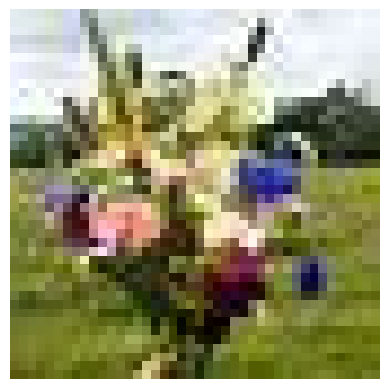

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=1000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



--------------------------------------------------------------------------------
Generated text for Positive:
Write a cheerful passage about a happiness.

To a person who has spent time with a happy person, you might expect that there are two things: the person has a positive attitude, and the person has a negative attitude.

But, the person does not have a positive attitude. He has a negative attitude. He uses the word positive. He uses the word negative. In other words, the person has a negative attitude. The person uses the word negative as a means to try and find a way to find a way to find a happiness.

In this way, a person who has a negative attitude becomes happier.

When you talk to a person you are working with, you will often find that they are happy. They are happy because they have a positive attitude, and they are happy because they use the word positive.

The good news is, you can always find a way to find a way to find a happy person.

Now, I will discuss the two aspec

Device set to use cpu



----------------------------------------
Positive music generated successfully


In [29]:
test_dir = '/root/.cache/kagglehub/datasets/imsparsh/audio-speech-sentiment/versions/2/TEST'
file_name = input("Enter the file name (with extension) from the test directory: ")
process_single_file(test_dir, file_name)
